# The GDSCTools library 
Nore that in this notebook, we need the following code but this may not be required in a script or a standard Python shell if pylab is already loaded.

## Regression methods

Currently (v0.15), we have 3 classes available that implements 3 regression methods namely:

- GDSCElasticNet
- GDSCRidge
- GDSCLasso

In the following, we will only use the GDSCElasticNet class but one can use other regression methods with the same usage.

## Features

- Train a model for a given alpha with a cross validation (CV)
- Scan alpha parameter, repeating the model training with CV
- Find the best alpha parameter automatically using CV
- Check significance of the Pearson correlation with random models
- Plot importances and weights of model coefficients
- Identify drugs of interest automatically


In [1]:
# For ipython notebooks only
%pylab inline
rcParams['figure.figsize'] = 10,5
#import warnings
#warnings.simplefilter('ignore', 'DeprecationWarning')

Populating the interactive namespace from numpy and matplotlib


Then, we can import some functionalities from GDSCtools library

In [2]:
from gdsctools import gdsctools_data
from gdsctools import regression
from gdsctools import GenomicFeatures, IC50     # optional

You may import everything in one go as follows::
        
    from gdsctools import *

## The Data
Let us get some data to play with. First, we get the drug responses from the v17 data set (*ic50* variable here below). Second, we read the genomic features for the same version (*gf* here below). 

An IC50 data set with 988 cell lines and Nd=265 drugs

In [3]:
ic50 = gdsctools_data("test_IC50.csv")
ic50 = gdsctools_data("IC50_v17.csv.gz")
IC50(ic50)

IC50 object <Nd=265, Nc=988>

Genomic feature data with 988 cell lines and Nf features. Yet, this data set is quite large hence the selection of only a subset of the features.

In [4]:
gf = gdsctools_data("genomic_features_v17.csv.gz")
# to speed up computation, we keep only 50 features:
gf = GenomicFeatures(gf)
gf.df = gf.df[["TISSUE_FACTOR", "MSI_FACTOR"] + list(gf.df.columns[219:271])]
gf

GenomicFeatures <Nc=988, Nf=52, Nt=27>

## The regression

From the regression module, we can use the **GDSCElasticNet** class. It takes as input a 
drug response matrix and a genomic features matrix. See the ANOVA analysis
or http://gdsctools.readthedocs.org documentation for details about the data formats.

In [5]:
gd = regression.GDSCElasticNet(ic50, gf)

Data are not normalised. However, one can force the X data (features) to be standarised (mean is substracted and result divided by the standard deviation). To do so, uncomment the following statement.

In [6]:
# gd.scale = True

**Note:** The ElasticNet like Lasso and Ridge methods have a parameter alpha, which will be tuned and of paramount importance in the next sections. The Elastic Net has also a l1_ratio parameter (0.5 by default). Let us emphasize the different terminology use in scikit-learn and the R package glmnet:

| sklearn  |  glmnet |
|-----------------------
|l1_ratio  | alpha|
|alpha     | lambda|




## Get the best model

Our first objective is to get the best model that is the best set of parameters (alpha parameter). This can be achieved using a cross validation strategy. In GDSCTools, this can be achieved in one go using  the runCV function. Let us pick a drug identifier known to have a large pearson correlation. Its identifier being 1047 in the present data set

In [7]:
drugid = 1047

Just call this method (**runCV**).

In [8]:
res = gd.runCV(drugid, n_folds=10)

Best alpha on 10 folds: 0.0153312472389 (-4.18 in log scale); Rp=0.563829993308


This is the fastest way in GDSCTools to get the best alpha parameter (highest pearson correlation). For performance reasons, there is no plot being shown. The returned objects contains information such as the best alpha parameter

In [9]:
res.alpha, res.ln_alpha

(0.015331247238941557, -4.1778622300509891)

Note that in general we will use a log scale alpha value (*ln alpha*):

## Importance features

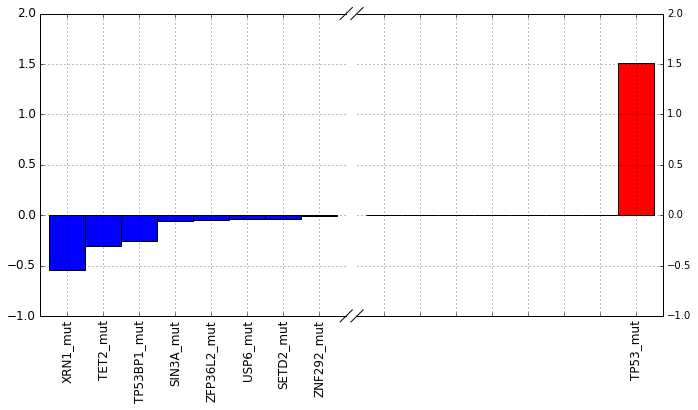

In [10]:
alpha = 0.01159
best_model = gd.get_model(alpha=alpha)
res = gd.plot_weight(drugid, best_model)

Here we see that TP53_mut feature is predominent.

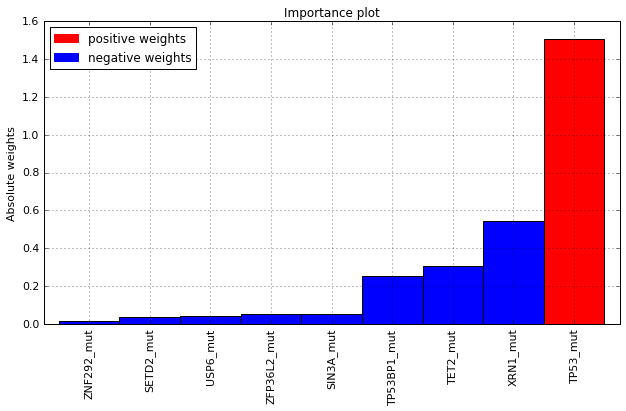

In [11]:
res = gd.plot_importance(drugid, model=gd.get_model(alpha=alpha))

In [12]:
res[res.weight !=0]

,weight
name,
SETD2_mut,-0.037432
SIN3A_mut,-0.054333
TET2_mut,-0.305070
TP53_mut,1.506210
TP53BP1_mut,-0.253850
USP6_mut,-0.040929
XRN1_mut,-0.541888
ZFP36L2_mut,-0.052753
ZNF292_mut,-0.013491


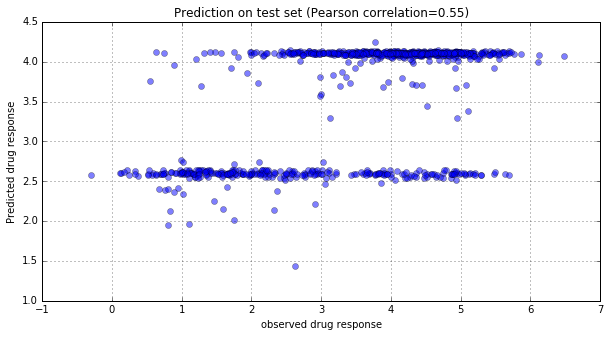

In [13]:
# One CV for a given alpha
# plots the prediction of the model for all data
scores = gd.fit(drugid, alpha=alpha)

In [14]:
all_scores = []
for this in range(100):
    scores = gd.fit(drugid, alpha=0.08, show=False, shuffle=True, randomize_Y=False)
    all_scores.extend(scores)
random_scores = []
for this in range(100):
    scores = gd.fit(drugid, alpha=0.08, show=False, shuffle=True, randomize_Y=True)
    random_scores.extend(scores)
    

The scores contains the pearson correlation for each K-fold

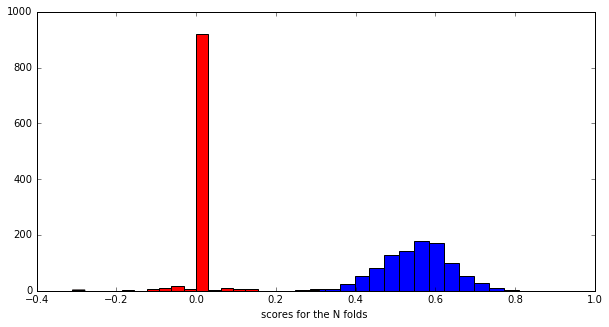

In [15]:
# scores returned corresponds to the N=10 KFold scores
_ = hist(all_scores,bins=20); xlabel('scores for the N folds ')
_ = hist(random_scores,bins=20, color="r"); xlabel('scores for the N folds ')

## Tuning alpha manually (and plotting)

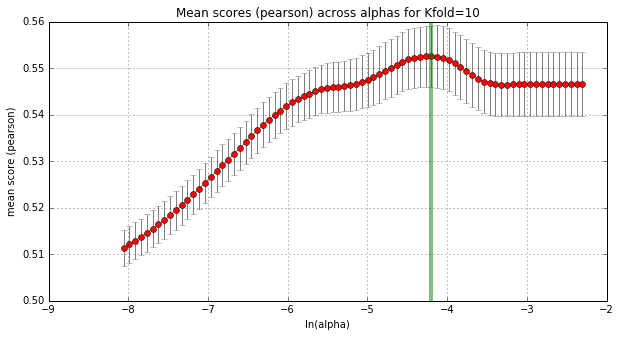

In [16]:
results = gd.tune_alpha(drugid, alpha_range=(-3.5,-1))

In [17]:
results

{'alpha_best': 0.015038869469554102,
 'ln_alpha': -4.1971171315334503,
 'maximum_Rp': 0.55257352697582773}

In [18]:
results["ln_alpha"]

-4.1971171315334503

This is not and runCV is recommended. 
- shuffle
- runCV gives stochastic answer while fitCV does not

In [19]:
alphas = []
Rps = []
from easydev import Progress
pb = Progress(len(gd.drugIds))
count = 0
for drug in gd.drugIds:
    res = gd.runCV(drug, n_folds=10, verbose=False)
    alphas.append(res.alpha)
    Rps.append(res.Rp)
    pb.animate(count)
    count += 1
    

 [-----------------99%----------------- ] 264 of 265 complete in 29.6 sec

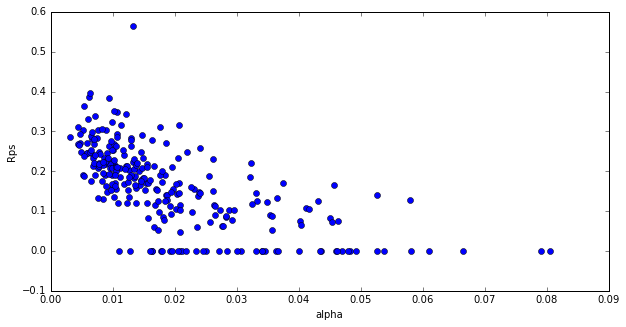

In [20]:
plot(alphas, Rps, "o")
xlabel("alpha")
ylabel("Rps")

In [21]:
best_alpha = 0.085

In [22]:
import pandas as pd
df = pd.DataFrame({"Rps":Rps, "drug": gd.drugIds})
df[df.Rps > 0.38]

,Rps,drug
2,0.386675,5
9,0.383882,32
29,0.397501,86
205,0.565318,1047


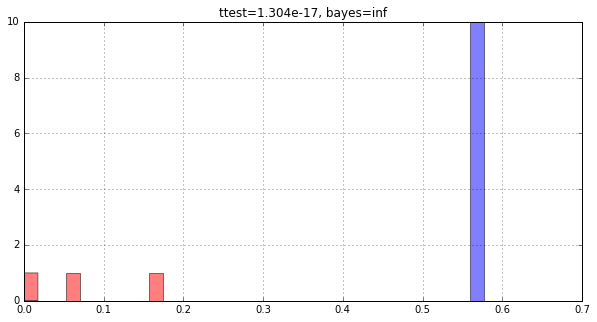

In [23]:
# Checking the validity of runCV on N instances
res = gd.check_randomness(1047, N=10)

We can also now look at the weights for that model:
    

Found STK11_mut with 12 events
Found TP53_mut with 589 events
Found STK11_mut,TP53_mut with 11 events
Found STAG2_mut,TP53_mut with 17 events


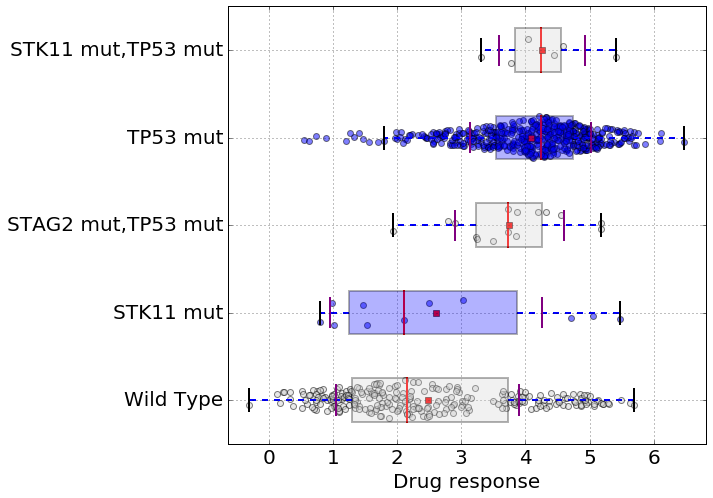

In [24]:
res = gd.boxplot(drugid, model=gd.get_model(alpha=best_alpha), n=10, bx_vert=False)

 [-----------------100%-----------------] 265 of 265 complete in 31.5 sec

/home/cokelaer/anaconda2/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


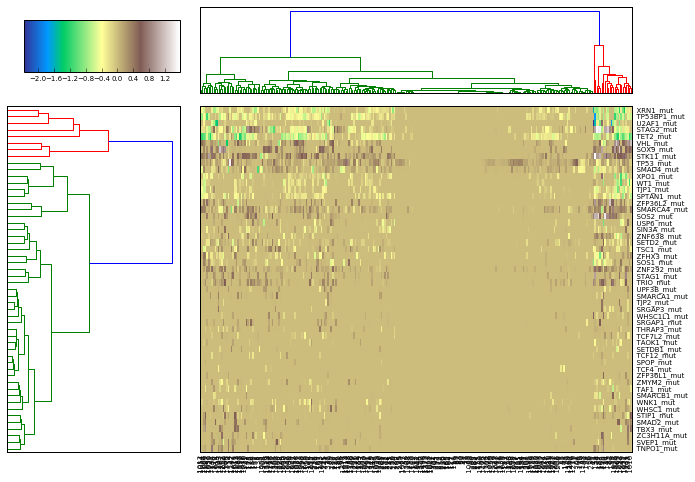

In [25]:
res = gd.dendogram_coefficients(cmap="terrain")

In [26]:
tt = []
bayes = []
Rp = []
from easydev import Progress
pb = Progress(len(gd.drugIds))
for i, this in enumerate(gd.drugIds):
    res = gd.check_randomness(this, 4, show=False)
    tt.append(res['ttest_pval'])
    bayes.append(res['bayes_factor'])
    Rp.append(mean(res['scores']))
    pb.animate(i+1)

 [-----------------100%-----------------] 265 of 265 complete in 305.3 sec

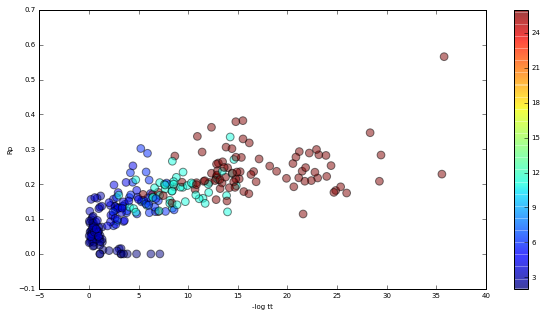

In [27]:
bayes = [x if not np.isinf(x) else 25 for x in bayes]
scatter(-log(tt), Rp, c=[1+x for x in bayes], s=60, alpha=0.5)
colorbar()
ylabel("Rp"); 
xlabel("-log tt")
#xlim([0,40])
#ylim([0,25])
#plot(-log(tt), Rp, "ro", alpha=0.5)

In [28]:
import pandas as pd
df = pd.DataFrame({"drugid": gd.drugIds, "Rp":Rp, "logtt":-log(tt), "bayes":bayes})

In [29]:
df.query("Rp>0.25 and logtt>10 and bayes>12")

,Rp,bayes,drugid,logtt
0,0.284316,25.0,1,23.172616
2,0.363093,25.0,5,12.353368
4,0.292166,25.0,9,11.411325
5,0.337034,25.0,11,10.931647
9,0.382192,25.0,32,15.521127
14,0.260645,25.0,41,13.046645
29,0.379172,25.0,86,14.806449
30,0.306148,25.0,87,13.825462
31,0.301819,25.0,88,14.418746
37,0.329767,25.0,110,15.533358
